In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

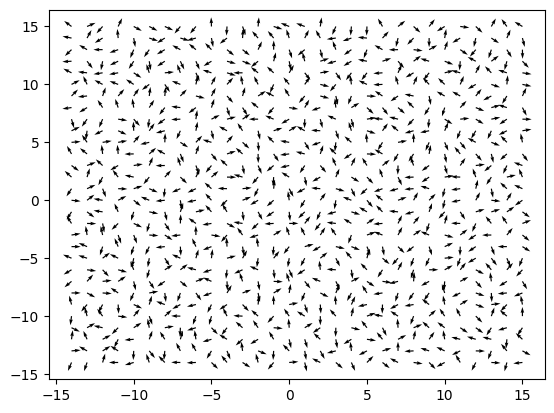

In [12]:
n = 30
x_grid, y_grid = np.mgrid[-n // 2 + 1:n // 2 + 1, -n // 2 + 1:n // 2 + 1]

theta = np.random.rand(n, n) * 2 * np.pi
omega = np.random.rand(n, n)
x = np.cos(theta)
y = np.sin(theta)

plt.quiver(x_grid, y_grid, x, y);

B_x = (-0.26x + -0.90y) / sqrt(x^2 + y^2)
B_y = (-0.80x + -0.90y) / sqrt(x^2 + y^2)


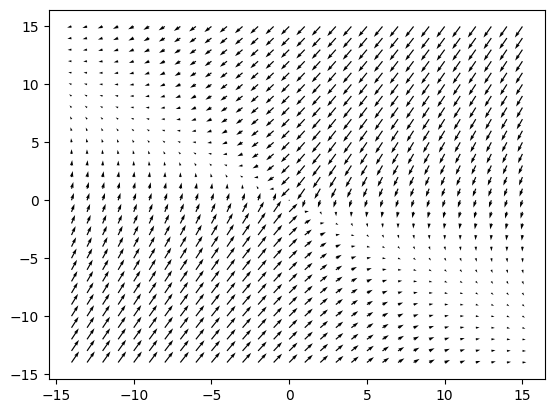

In [13]:
def B(x_grid, y_grid, a, b, c, d):
    B_x = a * x_grid + b * y_grid
    B_y = c * x_grid + d * y_grid

    B_x = B_x / np.sqrt(x_grid**2 + y_grid**2 + 1e-10)
    B_y = B_y / np.sqrt(x_grid**2 + y_grid**2 + 1e-10)
    return B_x, B_y

a, b, c, d = np.random.rand(4) * 2 - 1

print(f'B_x = ({a:.2f}x + {b:.2f}y) / sqrt(x^2 + y^2)')
print(f'B_y = ({c:.2f}x + {d:.2f}y) / sqrt(x^2 + y^2)')

B_x, B_y = B(x_grid, y_grid, a, b, c, d)
B_angle = np.arctan2(B_y, B_x)
B_mag = np.sqrt(B_x**2 + B_y**2)

plt.quiver(x_grid, y_grid, B_x, B_y);

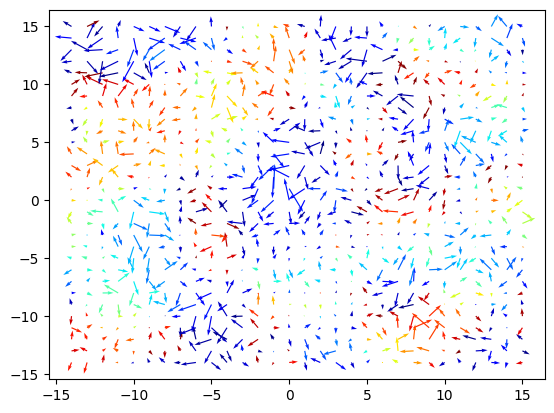

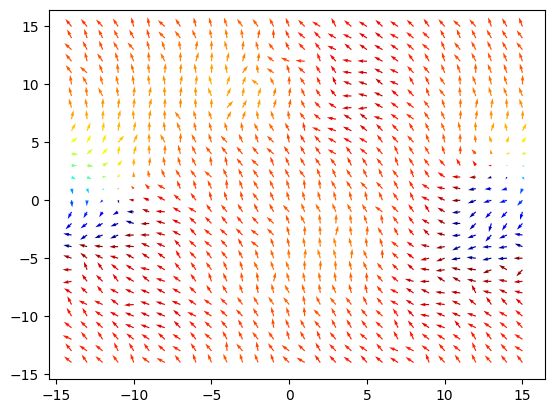

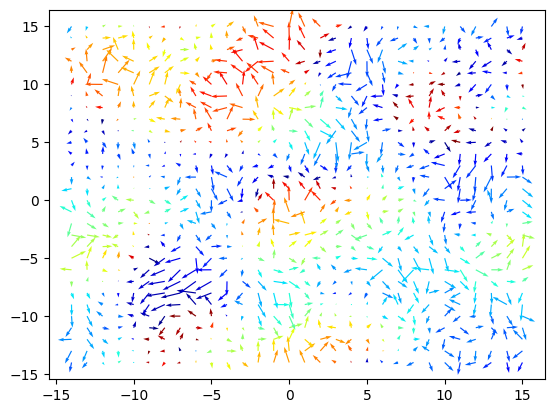

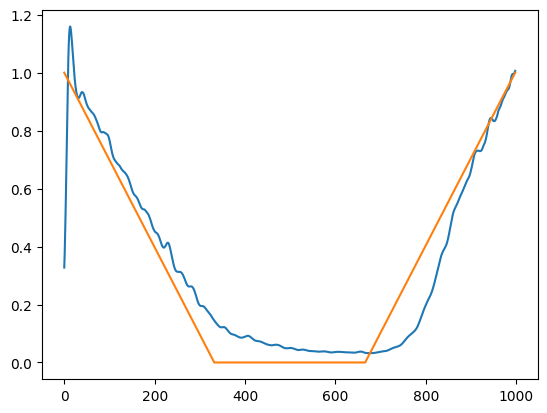

In [14]:
alpha = 1
beta = 0
gamma = 1
dt = 1e-1
n_cycles = 1000

temps = np.concatenate((np.linspace(1, 0, n_cycles//3), np.zeros(n_cycles//3), np.linspace(0, 1, n_cycles//3)))

avg_temps = []

for idx, t in enumerate(temps):
    x_up = np.roll(x, 1, axis=0)
    x_down = np.roll(x, -1, axis=0)
    x_left = np.roll(x, 1, axis=1)
    x_right = np.roll(x, -1, axis=1)

    y_up = np.roll(y, 1, axis=0)
    y_down = np.roll(y, -1, axis=0)
    y_left = np.roll(y, 1, axis=1)
    y_right = np.roll(y, -1, axis=1)

    x_neighbors = x_right + x_left + x_up + x_down
    y_neighbors = y_right + y_left + y_up + y_down

    theta_neighbors = np.arctan2(y_neighbors, x_neighbors)

    force_nieghbors = np.sin(theta_neighbors - theta)
    force_field = np.sin(B_angle - theta) * B_mag

    force = alpha * force_nieghbors + beta * force_field

    avg_temp = np.mean(omega**2)
    avg_temps.append(avg_temp)
    thermostat = gamma * (t - avg_temp) * omega # Nose thermostat
    
    # Verlet integration
    omega += dt * (force + thermostat)
    theta += dt * omega
    theta %= 2 * np.pi

    x = np.cos(theta)
    y = np.sin(theta)

    if idx == len(temps)//2:
        beta = 0
    if idx in [0,len(temps)//2, len(temps)-1]:
        n_neighbors = 5
        x_average = convolve(x, np.ones((n_neighbors, n_neighbors)) / n_neighbors**2, mode='wrap')
        y_average = convolve(y, np.ones((n_neighbors, n_neighbors)) / n_neighbors**2, mode='wrap')

        magnetization_angle = np.arctan2(y_average, x_average)
        magnetization_mag = np.sqrt(x_average**2 + y_average**2)

        plt.quiver(x_grid, y_grid, x*magnetization_mag, y*magnetization_mag, magnetization_angle, cmap='jet')
        plt.show()

plt.plot(avg_temps)
plt.plot(temps)
plt.show();

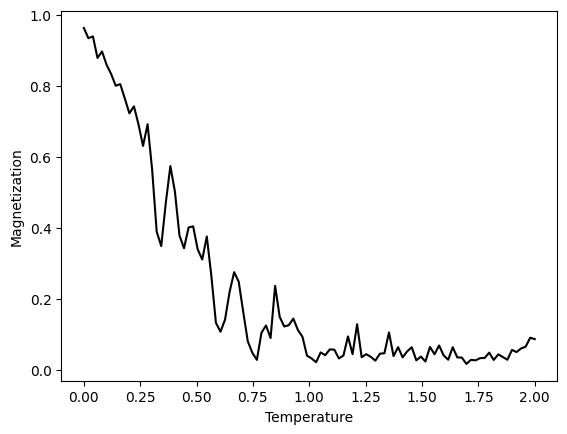

In [15]:
alpha = 1
beta = 0
gamma = 1
dt = 1e-1
n_cycles = 10000
cycles_per_temp = 100

temps = np.linspace(2, 0, n_cycles // cycles_per_temp)

avg_temps = []

M = []

for t in temps:
    m = []
    for i in range(cycles_per_temp):
        x_up = np.roll(x, 1, axis=0)
        x_down = np.roll(x, -1, axis=0)
        x_left = np.roll(x, 1, axis=1)
        x_right = np.roll(x, -1, axis=1)

        y_up = np.roll(y, 1, axis=0)
        y_down = np.roll(y, -1, axis=0)
        y_left = np.roll(y, 1, axis=1)
        y_right = np.roll(y, -1, axis=1)

        x_neighbors = x_right + x_left + x_up + x_down
        y_neighbors = y_right + y_left + y_up + y_down

        theta_neighbors = np.arctan2(y_neighbors, x_neighbors)

        force_nieghbors = np.sin(theta_neighbors - theta)
        force_field = np.sin(B_angle - theta) * B_mag

        force = alpha * force_nieghbors + beta * force_field

        avg_temp = np.mean(omega**2)
        avg_temps.append(avg_temp)
        thermostat = gamma * (t - avg_temp) * omega # Nose thermostat
        
        # Verlet integration
        omega += dt * (force + thermostat)
        theta += dt * omega
        theta %= 2 * np.pi

        x = np.cos(theta)
        y = np.sin(theta)

        if i > cycles_per_temp//2:
            m.append(np.sqrt(np.mean(x)**2 + np.mean(y)**2))

    M.append(np.mean(m))

plt.plot(temps, M, color='black')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show();